In [1]:
import json
import polars as pl
import torch
from tqdm import tqdm
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, IterableDataset

seed_val = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(seed_val)
random.seed(seed_val)
np.random.seed(seed_val)

In [2]:
with open("./params.json", mode = "r", encoding = "utf-8") as f:
    data = json.load(f)
    model_path = data["model_path"]
    dataset_path_train = data["dataset_path"]["train"]
    dataset_path_test = data["dataset_path"]["test"]
    num_single_sample_timesteps = data["num_single_sample_timesteps"]
    input_window_length = data["input_window_length"]
    label_window_length = data["label_window_length"]
    input_features = data["input_features"]
    label_features = data["label_features"]

    # Usually window_stride = 1 since we want to check each input window
    window_stride = 20

In [3]:
class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, dropout, max_len):
        super().__init__()
        self.dropout = torch.nn.Dropout(dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype = torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe.unsqueeze(0))

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

In [4]:
from transformers import T5Config, T5ForConditionalGeneration

class TimeSeriesHuggingFaceTransformer(T5ForConditionalGeneration):
    def __init__(self, input_dim, output_dim, d_model, num_head, num_encoder_layers, num_decoder_layers, position_wise_ffn_dim, dropout):
        # batch_first = True in all huggingface models
        config = T5Config(
            vocab_size = 1, # No vocab --> = 1 is placeholder
            d_model = d_model,
            num_heads = num_head,
            num_layers = num_encoder_layers,
            num_decoder_layers = num_decoder_layers,
            d_ff = position_wise_ffn_dim,
            dropout = dropout,
            decoder_start_token_id = 0,
            tie_word_embeddings = False,
            relative_attention_num_buckets = 32, 
            d_kv = d_model // num_head,

            output_attention = True    # To get multi-head attentions (num_attention_head values each)
        )
        
        super().__init__(config)    # Creates model with random weights

        self.encoder.embed_tokens = torch.nn.Linear(input_dim, d_model)     # Embedding layer for input
        self.decoder.embed_tokens = torch.nn.Linear(output_dim, d_model)    # Embedding layer for output
        
        self.lm_head = torch.nn.Linear(d_model, output_dim, bias = False)   # Last linear before output
        
        self.output_dim = output_dim

        self.bos_token = torch.nn.Parameter(torch.empty(1, 1, output_dim))
        torch.nn.init.normal_(self.bos_token, mean = 0.0, std = 1.0)

        self.attention_weights = {
            "encoder_attention": [],
            "decoder_attention": [],
            "cross_attention": []
        }

    def forward(self, inputs_embeds, decoder_inputs_embeds, **kwargs):
        outputs = super().forward(
            inputs_embeds = inputs_embeds,
            decoder_inputs_embeds = decoder_inputs_embeds,
            **kwargs
        )

        if(outputs.encoder_attentions):
            self.attention_weights["encoder_attention"].extend(outputs.encoder_attentions)
            
        if(outputs.decoder_attentions):
            self.attention_weights["decoder_attention"].extend(outputs.decoder_attentions)
            
        if(outputs.cross_attentions):
            self.attention_weights["cross_attention"].extend(outputs.cross_attentions)    # Encoder-Decoder Attention

        return outputs

/users/labnet5/gr5/abahari/Documents/Thesis/src/thesis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
class WindowedIterableDataset(IterableDataset):
    def __init__(
            self,
            dataset_path,
            stats,
            input_features,
            label_features,
            num_single_sample_timesteps,
            stride,
            input_window_length,
            chunk_size = 512
        ):
        '''
            input_df & label_df
                Type: Numpy
                Shape: Number of time-series, Number of time-steps, Number of input features
            
            input_features & label_features
                Type: List

            multi worker setup can cause problems here!
            There is a fix though! Assign unique data iteration based on worker info.
        '''

        super().__init__()
        
        self.dataset_path = dataset_path
        self.input_features = input_features
        self.label_features = label_features
        self.num_single_sample_timesteps = num_single_sample_timesteps
        self.stride = stride
        self.input_window_length = input_window_length
        self.chunk_size = chunk_size
        self.means = stats.select(
            [col for col in stats.columns if "_mean" in col]
        ).to_numpy()
        self.stds = stats.select(
            [col for col in stats.columns if "_std" in col]
        ).to_numpy()
        self.stds[self.stds == 0] = 10 ** -8
    
    def __iter__(self):
        df_reader = pl.read_csv_batched(self.dataset_path, batch_size = self.chunk_size)

        while(True):
            new_chunk = df_reader.next_batches(1)
            if(new_chunk is None):
                break
            
            data_chunk = new_chunk[0]
            data_chunk = (
                data_chunk
                .drop(["id"])    # No eps or n_0_squared!
                .select(
                    pl.col("*").str.json_decode()
                )
                # .with_columns(
                #     eta_list = pl.col("eta_list").list.eval(pl.element().flatten(), parallel = True)
                # )
            )
            input_df = data_chunk.select(self.input_features).explode("*").to_numpy().reshape(data_chunk.shape[0], self.num_single_sample_timesteps, len(self.input_features))
            label_df = data_chunk.select(self.label_features).explode("*").to_numpy().reshape(data_chunk.shape[0], self.num_single_sample_timesteps, len(self.label_features))

            # Permutation substitutes shuffle=True in Dataloader!
            for time_series_idx in np.random.permutation(data_chunk.shape[0]):
                for input_window_start_idx in range(0, self.num_single_sample_timesteps - self.input_window_length, self.stride):
                    label_window_start_idx = input_window_start_idx + self.input_window_length
                    
                    input_window = input_df[time_series_idx, input_window_start_idx: label_window_start_idx, :]
                    label_window = label_df[time_series_idx, label_window_start_idx: label_window_start_idx + label_window_length, :]
                    input_labels = label_df[time_series_idx, input_window_start_idx:, :]

                    input_window = (input_window - self.means) / self.stds
                    label_window = (label_window - self.means) / self.stds
                    input_labels = (input_labels - self.means) / self.stds

                    input_window = torch.tensor(input_window, dtype = torch.float)
                    label_window = torch.tensor(label_window, dtype = torch.float)
                    input_labels = torch.tensor(input_labels, dtype = torch.float)

                    yield input_window, label_window, input_labels

In [6]:
stats = (
    pl.scan_csv(
        dataset_path_train
    )
    .select(
        input_features
    )
    .select(
        pl.col("*").str.json_decode(dtype = pl.List(pl.Float32))
    )
    .explode("*")
    .select([
        pl.col("*").mean().name.suffix("_mean"),
        pl.col("*").std().name.suffix("_std")
    ])
).collect(engine = "streaming")

df_test = WindowedIterableDataset(
    dataset_path = dataset_path_test,
    stats = stats,
    input_features = input_features,
    label_features = label_features,
    num_single_sample_timesteps = num_single_sample_timesteps,
    stride = window_stride,
    input_window_length = input_window_length
)

data_loader_test = DataLoader(
    df_test,
    batch_size = None,
    pin_memory = True
)

## Prediction

In [7]:
model = torch.load(model_path, weights_only = False).to(device)
model.eval()

TimeSeriesHuggingFaceTransformer(
  (shared): Embedding(1, 64)
  (encoder): T5Stack(
    (embed_tokens): Linear(in_features=5, out_features=64, bias=True)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=64, out_features=64, bias=False)
              (k): Linear(in_features=64, out_features=64, bias=False)
              (v): Linear(in_features=64, out_features=64, bias=False)
              (o): Linear(in_features=64, out_features=64, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=64, out_features=64, bias=False)
              (wo): Linear(in_features=64, out_features=64, bias=False)
              

0it [00:00, ?it/s, single_test_loss=0.004897]

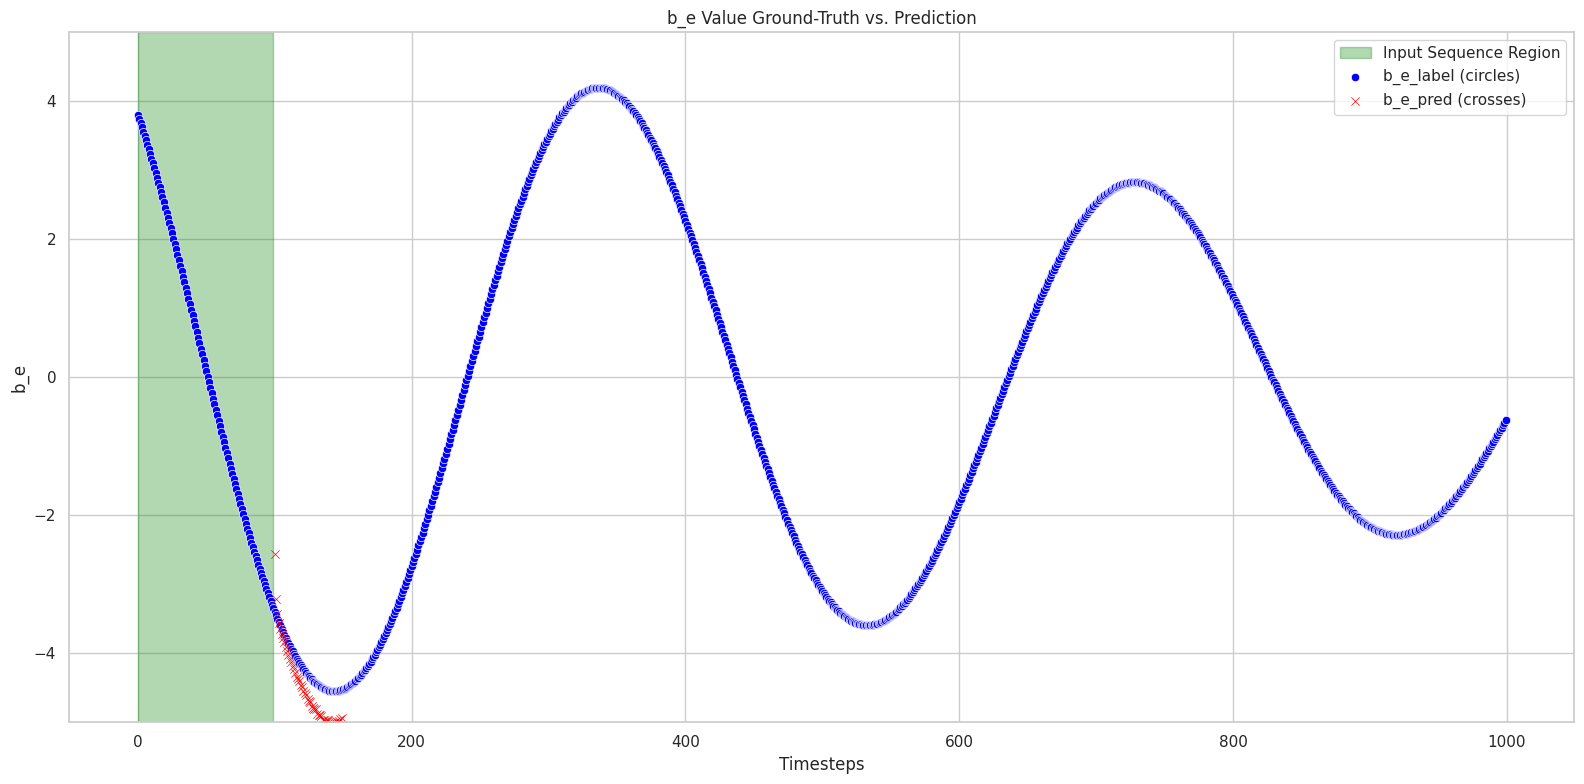

5it [00:00,  8.33it/s, single_test_loss=0.003927]

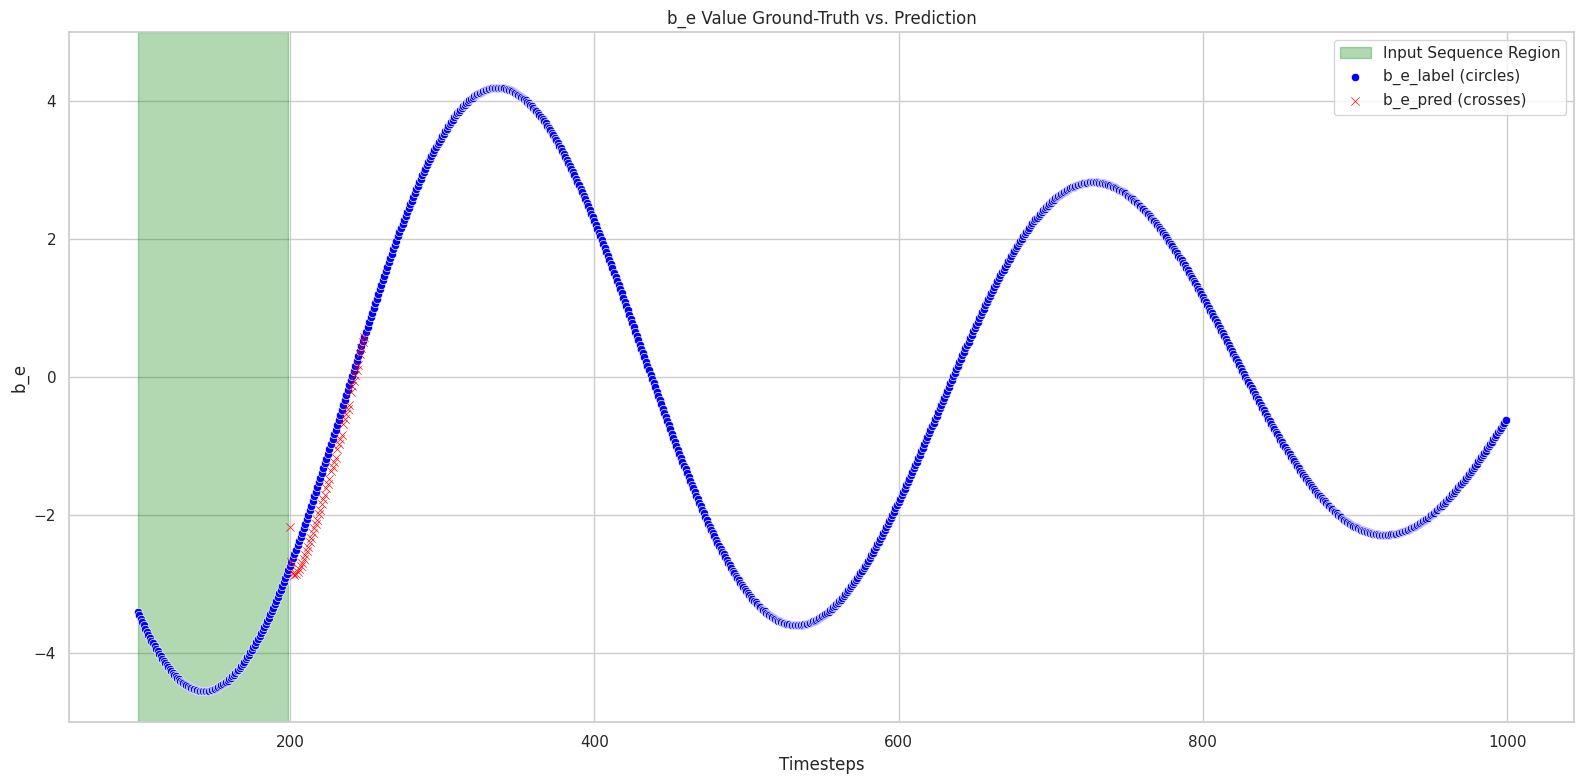

9it [00:01,  9.20it/s, single_test_loss=0.004901]

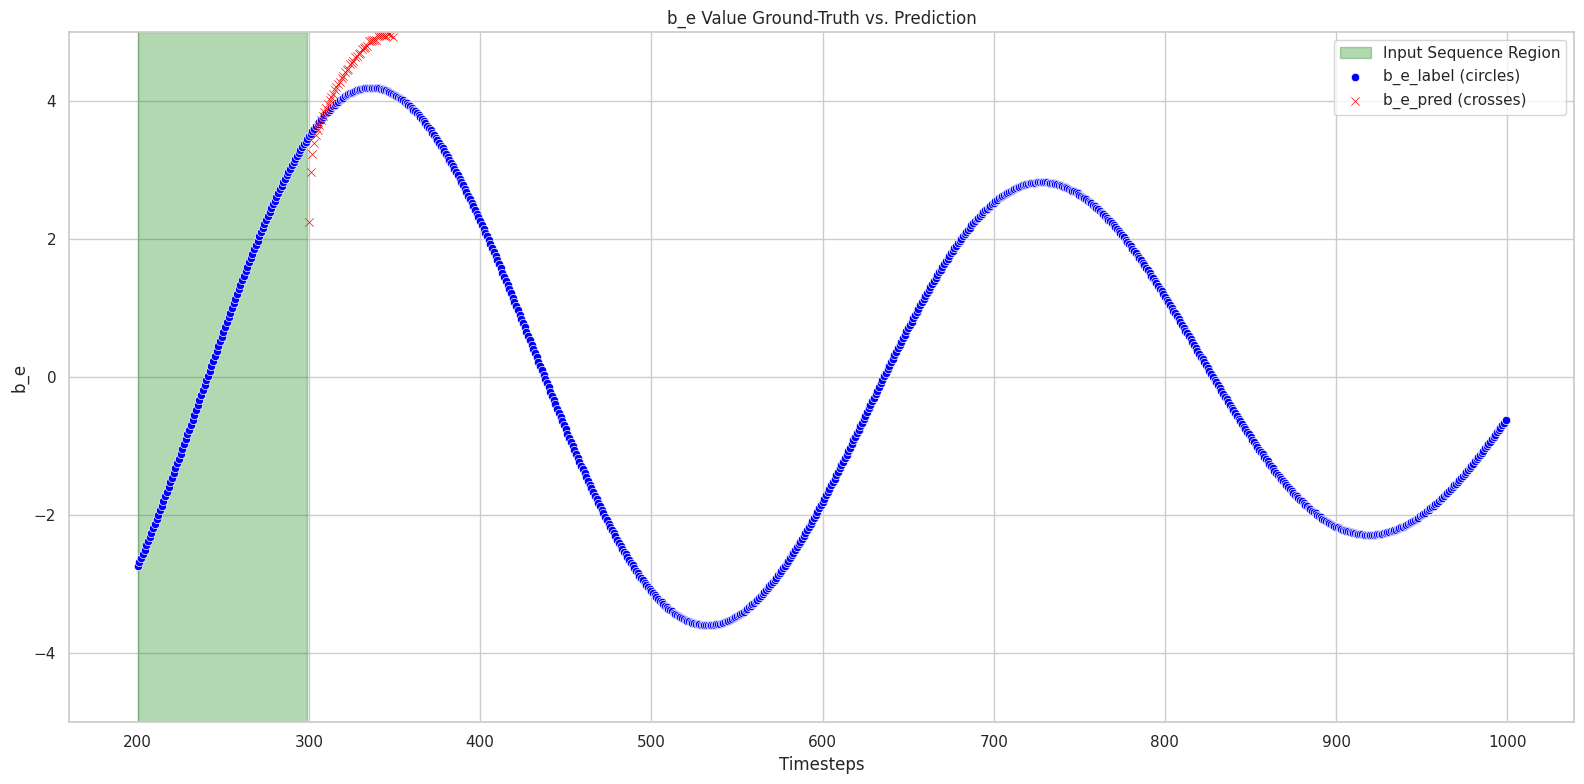

15it [00:01, 10.50it/s, single_test_loss=0.004631]

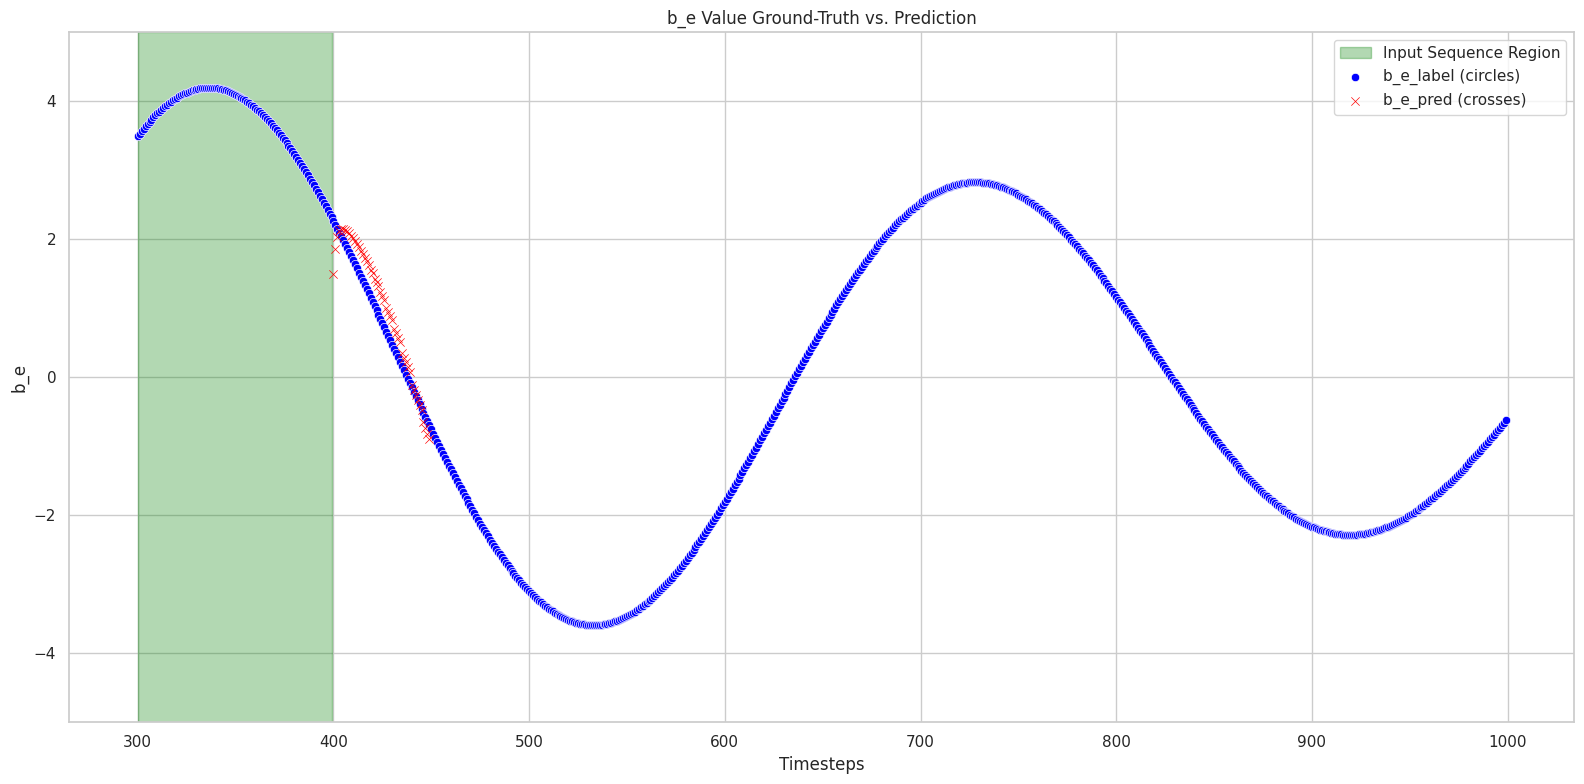

19it [00:02, 10.06it/s, single_test_loss=0.002854]

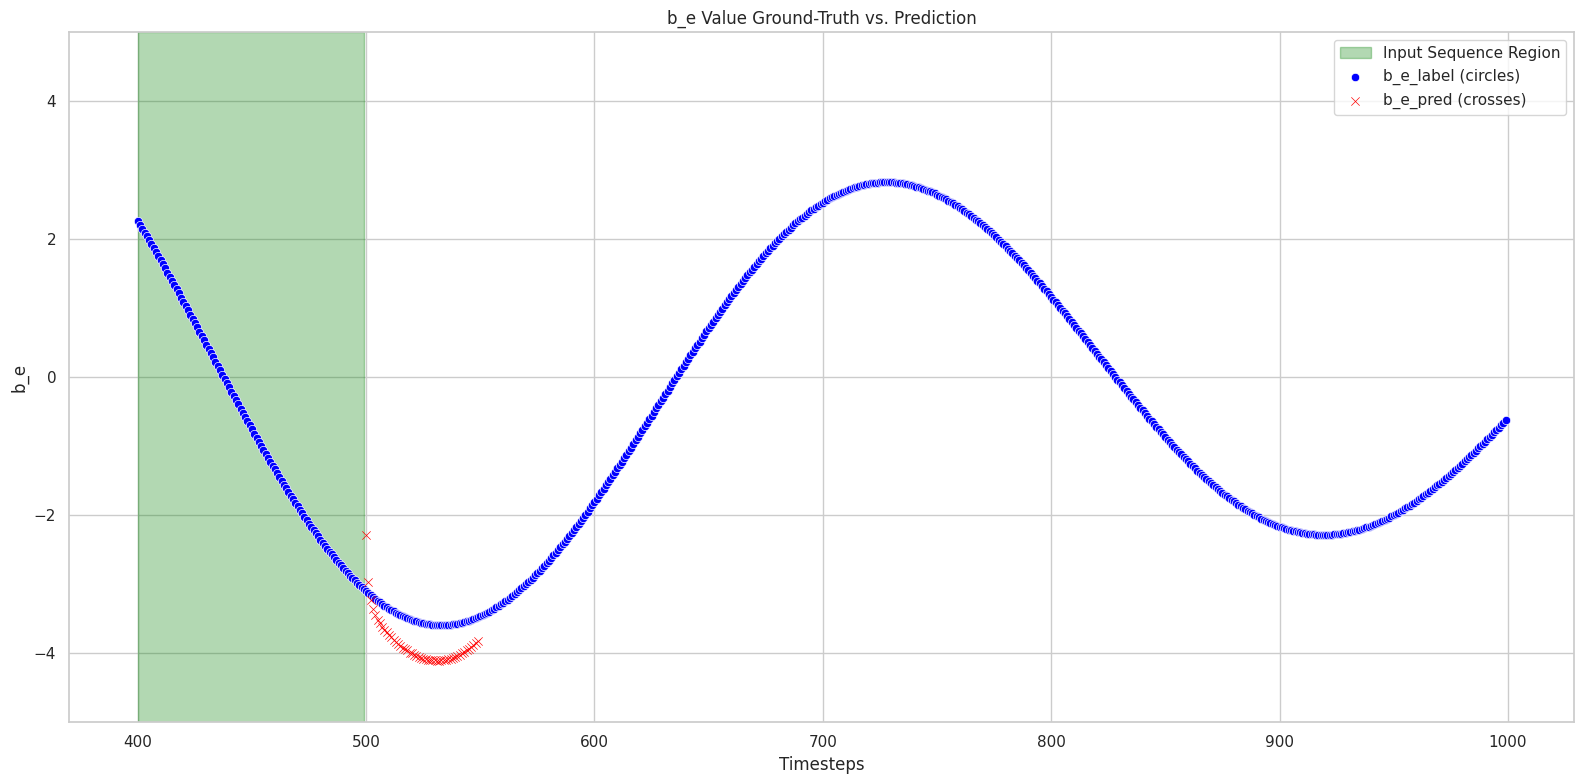

25it [00:02, 10.71it/s, single_test_loss=0.004176]

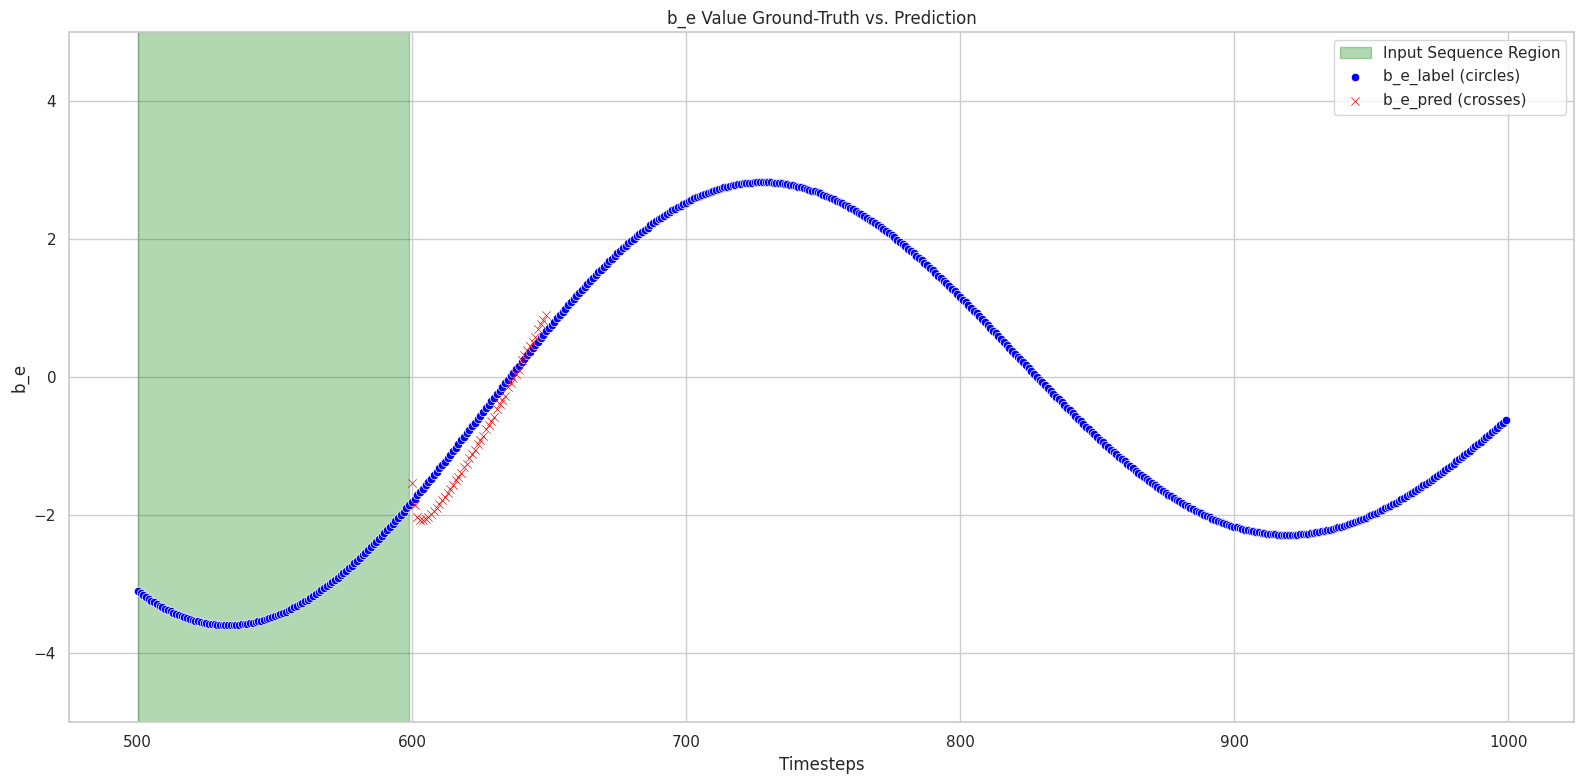

29it [00:03, 10.32it/s, single_test_loss=0.003980]

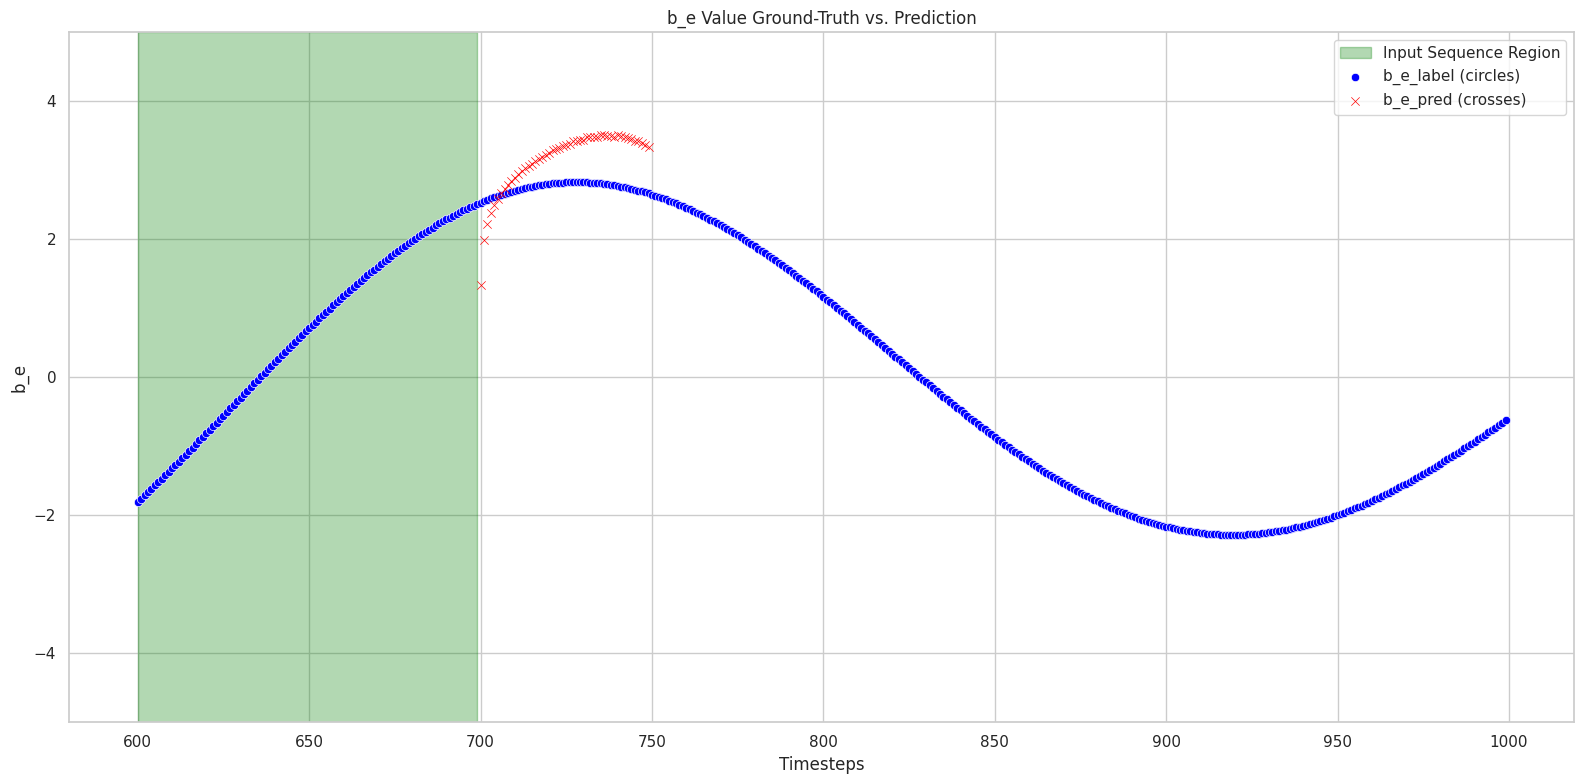

35it [00:03, 10.79it/s, single_test_loss=0.004937]

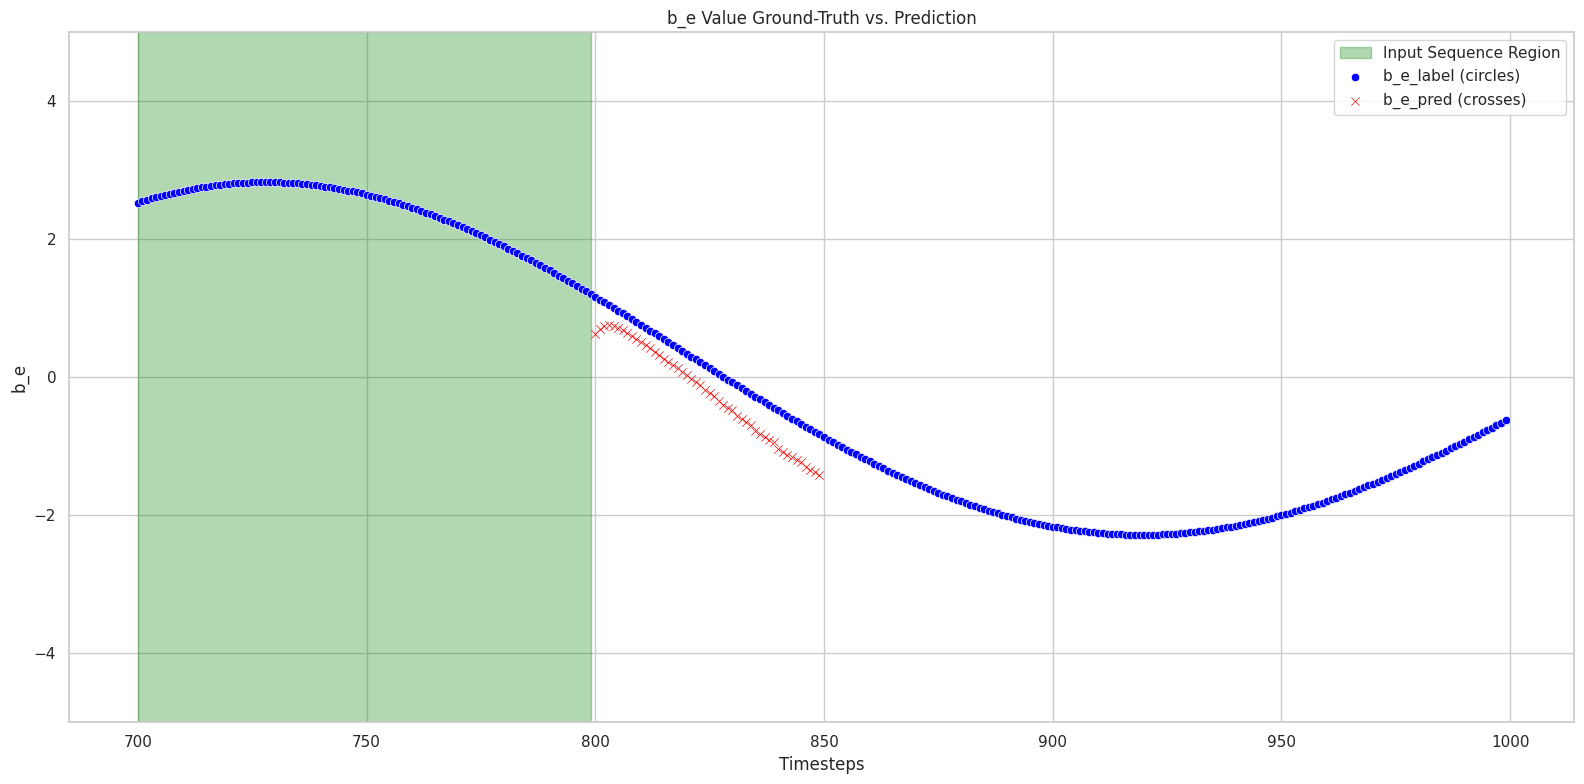

39it [00:04, 10.27it/s, single_test_loss=0.004995]

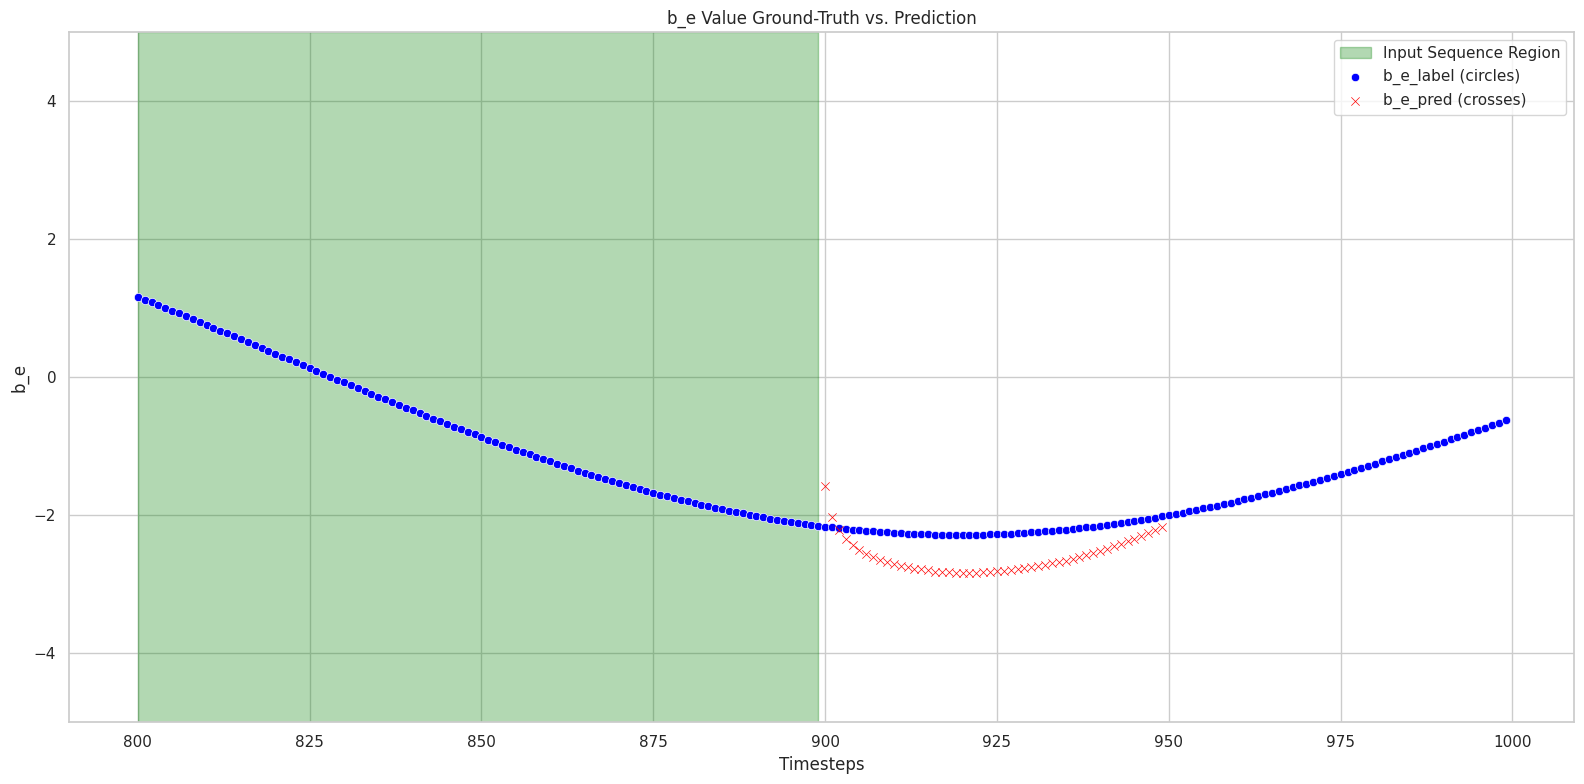

45it [00:04,  9.44it/s, single_test_loss=0.004731]



Single time-series inference done! Stopping inference...


In [8]:
test_loss = 0.0
test_progress_bar = tqdm(
    data_loader_test
)

criterion = torch.nn.MSELoss()
plot_counter = 0

with torch.no_grad():
    for test_i, (batch_x, batch_y, x_labels) in enumerate(test_progress_bar):
        if(test_i == len(range(0, num_single_sample_timesteps - input_window_length, window_stride))):
            print("\n\nSingle time-series inference done! Stopping inference...")
            break
        
        # Since we are not using batches we have to expand first dim so that one data point is considered a batch of size 1
        # Everything expects batches! --> unsqueeze(0) is like expand_dims(axis = 0)
        batch_x = batch_x.unsqueeze(0).to(device)
        batch_y = batch_y.unsqueeze(0).to(device)

        num_label_batch_samples, num_label_timesteps, num_label_features = batch_y.shape    # num_label_features == len(label_features)

        encoder_outputs = model.encoder(
            inputs_embeds = model.encoder.embed_tokens(batch_x)
        )

        # bos = torch.zeros(
        #     num_label_batch_samples, 1, num_label_features,
        #     dtype = torch.float,
        #     device = device
        # )

        bos = model.bos_token.expand(num_label_batch_samples, -1, -1)

        preds = torch.zeros(
            num_label_batch_samples, num_label_timesteps, num_label_features,
            dtype = torch.float,
            device = device
        )
        
        ################### Analyze This ########################
        # This is where KV caching is critical for speed.
        past_key_values = None

        for i in range(num_label_timesteps):
            # 4. Pass the current decoder input to the decoder
            # Use KV caching to only compute attention for the new token
            decoder_outputs = model.decoder(
                inputs_embeds = model.decoder.embed_tokens(bos),
                encoder_hidden_states = encoder_outputs.last_hidden_state,
                past_key_values = past_key_values,
                use_cache = True,
                return_dict = True
            )
            
            # 5. Extract the output for the *last* token
            # This is the new prediction
            decoder_last_hidden_state = decoder_outputs.last_hidden_state[:, -1:, :]

            # 6. Apply the final linear layer (lm_head) to get the prediction
            next_prediction = model.lm_head(decoder_last_hidden_state) # Shape: (batch_size, 1, num_label_features)

            preds[:, i, :] = next_prediction.squeeze(1)

            # 8. Update past_key_values for the next iteration
            # This is the core of KV caching
            past_key_values = decoder_outputs.past_key_values

            # 9. The prediction for the current step becomes the input for the next step
            bos = next_prediction
        ################### Analyze This ########################
        
        loss = criterion(preds, batch_y)
        test_progress_bar.set_postfix({
            "single_test_loss": f"{loss.item():.6f}"
        })

        means = stats.select(
            [col for col in stats.columns if "_mean" in col]
        ).to_numpy()

        stds = stats.select(
            [col for col in stats.columns if "_std" in col]
        ).to_numpy()

        if(plot_counter % input_window_length == 0):
            x = list(range(num_single_sample_timesteps))

            feature = "b_e"

            feature_idx = label_features.index(feature)

            feature_label = batch_y[:, :, feature_idx].cpu()[0]
            feature_pred = preds[:, :, feature_idx].cpu()[0]
            feature_x_labels = x_labels[:, feature_idx]

            feature_pred = (feature_pred * stds[0, feature_idx]) + means[0, feature_idx]
            feature_label = (feature_label * stds[0, feature_idx]) + means[0, feature_idx]
            feature_x_labels = (feature_x_labels * stds[0, feature_idx]) + means[0, feature_idx]

            sns.set_theme(style = "whitegrid")
            fig, ax = plt.subplots(figsize = (16, 8))
            ax.set_ylim(-5, 5)

            ax.axvspan(
                x[plot_counter],
                x[plot_counter + input_window_length - 1],
                color = "green",
                alpha = 0.3,
                label = "Input Sequence Region"
            )

            sns.scatterplot(
                x = x[plot_counter:],
                y = feature_x_labels,
                marker = "o",
                label = f"{feature}_label (circles)",
                color = "blue",
                ax = ax
            )
            # sns.scatterplot(
            #     x = x[(input_window_length + plot_counter):],
            #     y = u_label,
            #     marker = "o",
            #     color = "blue",
            #     ax = ax
            # )
            sns.scatterplot(
                x = x[(input_window_length + plot_counter):(input_window_length + plot_counter + label_window_length)],
                y = feature_pred,
                marker = "x",
                label = f"{feature}_pred (crosses)",
                color = "red",
                ax = ax
            )

            ax.set_title(f"{feature} Value Ground-Truth vs. Prediction")
            ax.set_xlabel("Timesteps")
            ax.set_ylabel(feature)
            ax.legend()

            plt.tight_layout()
            plt.show()

            # last_decoder_layer_shared_attention = model.attention_weights["cross_attention"][-1][0]
            # avg_attention_weights = last_decoder_layer_shared_attention.mean(dim = 0).cpu().numpy()

            # for i in range(20):     # First 20 predictions following input sequence 
            #     output_row = avg_attention_weights[i, :]
            #     top_k_indices = np.argsort(output_row)[::-1][:10]    # Top 10 highest attention input timesteps
            #     top_k_scores = output_row[top_k_indices]
            #     print(f"Output Timestep {plot_counter + input_window_length + i + 1}: Input Timesteps {top_k_indices + plot_counter + 1} with scores {[f'{score:.5f}' for score in top_k_scores]}")


        plot_counter += window_stride